# TempAtt exp6: ctrl experiment (auditory passive)

### Load & preprocess data

In [9]:
clear
clc
% close all

In [10]:
% define Paths: replace XXX by your own path
origDir = '/XXX/exp6/'; %!
addpath(genpath(origDir)); cd(origDir)

% define data
SUJETS = 1:15;

In [11]:
% load data: 1 session per participant
IN = []; Dif = NaN(SUJETS(end),1);
for isuj = SUJETS
    subject = ['S' sprintf( '%02d', isuj ) ];
        ifile = dir(['TA18_' subject '_Control_1*.mat']);
        load([ifile.name])
        IN{isuj,1}  = X;
        Dif(isuj,1) = cfg.ndis;
    clear X subject ifile
end

In [12]:
% varnames & beat
varname = {'Proportion Correct', 'Mean RT (ms)', 'Hit IE (sec)'};
beats = cfg.fbeat(end:-1:1);

In [13]:
% extract data
OUT{1} = NaN(SUJETS(end), length(cfg.fbeat)); OUT{2} = OUT{1}; OUT{3} = OUT{2};
for isuj = SUJETS    
    for ibeat = 1:length(beats)
        y = IN{isuj}.beat == beats(ibeat);
        out{1} = IN{isuj}.iscor(y);
        out{2} = IN{isuj}.rt(y);        
        % nan rt >|< 2sd
            rtmin = mean(out{2}) -2*std(out{2});
            rtmax = mean(out{2}) +2*std(out{2});
            out{2}(out{2}>rtmax)  = NaN; out{2}(out{2}<rtmin) = NaN;
            out{1}(isnan(out{2})) = NaN;
        % avg trials
            OUT{1}(isuj,ibeat) = nanmean(out{1});
            OUT{2}(isuj,ibeat) = nanmean(out{2});
            OUT{3}(isuj,ibeat) = nanmean(out{2}) ./nanmean(out{1});
        clear out y rtmin rtmax
    end
end
clear IN  isuj ibeat

In [15]:
% define variable of interest
i0 = 1; % performance (or RT, or IE, see varname)
fit_order = 3; % fit order (n = 3)

In [17]:
% Fits per subject - define after rstudio analysis
xVec = (beats(end):0.01:beats(1));
Fit = [];
for j0 = 1:length(OUT{i0})
    x = OUT{i0}(j0,:);
    x = polyfit(log(beats), x, fit_order);
    if fit_order == 3
        Fit(j0) = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    elseif fit_order == 2
        Fit(j0) = exp(-(x(2)./(2.*x(1)))); % order 2
    end
end
Fit = real(Fit)';
nsuj = length(Fit);

In [18]:
% detect potential outliers (4std)
olr = find((Fit>(mean(Fit)+4*std(Fit))));

% control range of Fit fq (should be between [0, 3.2])
[min(Fit), max(Fit)]


ans =

    0.7476    2.0782



### Statistics

In [19]:
% statistics
fprintf('\nParametric repeated-measure Anova on %s \n', varname{i0})
[~,F,~,~] = repanova(OUT{i0}, 8, {'Beat'});

% compute fit quality
x = mean(OUT{i0},1);
    y = polyfit(log(beats), x, fit_order);
    y = polyval(y, log(beats));
[r,p] = corr(x', y', 'type', 'Spearman');
fprintf('\n%1.0fnd order fit: r2=%1.2f, p=%1.3f \n', fit_order, r*r, p)


Parametric repeated-measure Anova on Proportion Correct 
Beat                 F(  7.00, 98.00) =   8.932,	p = 0.0000

3nd order fit: r2=0.86, p=0.002 


### Figure

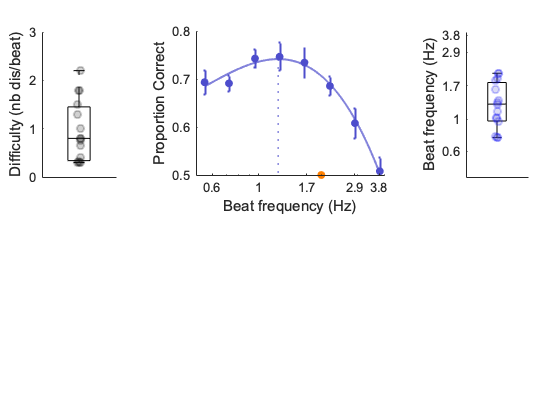

In [20]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])

% 1. Difficulty
h = subplot(2,4, 1); hold on
    pos = get(h, 'Position');
    set(h, 'Position', pos +[-.08 0 0 0] )
    boxplot(zeros(10,1), 'colors','k','Widths',.01)
boxplot(Dif,'boxstyle','outline', 'colors','k','OutlierSize',4,'Symbol','','Widths',0.6)
scatter(ones(size(Dif)).*(1+(rand(size(Dif))-0.5)/10),Dif, ...
    'MarkerFaceColor',[.1 .1 .1],'MarkerEdgeColor','k',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylim( [0, 3] )
    ylabel( 'Difficulty (nb dis/beat)' )
    xlim( [.0, 2] )
    set(gca,'XTick', [] )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    
    
% 3. boxplot individual preferred Fq
h = subplot(2,4, 4); hold on
    pos = get(h, 'Position');
    set(h, 'Position', pos +[.04 0 0 0] )  
    boxplot(zeros(10,1), 'colors','k','Widths',.01)
boxplot(Fit, 'boxstyle','outline', 'colors','k','OutlierSize',4,'Symbol','','Widths',0.6)
scatter(ones(nsuj,1).*(1+(rand(nsuj,1)-0.5)/10), Fit(:,1), ...
    'MarkerFaceColor',[.3 .3 .8], 'MarkerEdgeColor','b',...
    'MarkerFaceAlpha',.2,'MarkerEdgeAlpha',.2)
set(gca, 'FontSize', 10, 'FontName', 'Arial')
set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
xlim( [.0, 2] )
    set(gca,'XTick', [] )
ylabel( 'Beat frequency (Hz)' )
yticks( round(beats([end:-2:1 1]),1) )
    set(gca, 'YLim',[.4, 4], 'YScale', 'log' ) %!

% 2. plot performances
subplot(2,2, 1.5); hold on
x = bsxfun(@plus,bsxfun(@minus, OUT{i0}, mean(OUT{i0},2)), mean(OUT{i0}(:)));
errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.3 .3 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)

% + plot staircase
plot(2, .5, '.', 'color', [1 .5 .0], 'Linewidth', 2, 'MarkerSize', 15) %!
        
% + plot Fit
x = mean(OUT{i0},1);
    x = polyfit(log(beats), x, fit_order);
    freqpass = exp((-x(2)-sqrt(x(2).^2-3.*x(1).*x(3)))./(3.*x(1))); % order 3
    x = polyval(x, log(xVec));
    h = plot(xVec, x, 'color', [.3 .3 .8], 'Linewidth', 1.5);
    h.Color(4) = 0.7;

% + plot max fit
[~,b] = max(x);
maxpass = max(x);
h = line([xVec(b), xVec(b)], [.0, max(x)]);
    set(h, 'color', [.3 .3 .8], 'LineStyle', ':')
        
hold off
set(gca, 'FontSize', 10, 'FontName', 'Arial')
ylabel( varname{i0} )        
xlabel( 'Beat frequency (Hz)' )
set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
ylim( [.5, .8] ) %!
yticks( .5:.1:1 )       
    xticks( round(beats([end:-2:1 1]),1) )
    set(gca, 'XScale', 'log')
    xlim( [.5, 4] )

% Print figure
cd(origDir)
% print('figureS1','-dpng','-r600')
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figureS1.pdf

In [21]:
 fprintf('optimal beat frequency: mean = %1.2f Hz, med = %1.2f Hz, std = %1.3f Hz \n', mean(Fit), quantile(Fit,[.5]), std(Fit))
 fprintf('difficulty level:  mean = %1.2f , med = %1.2f , std = %1.3f  \n', mean(Dif), quantile(Dif,[.5]), std(Dif))
 fprintf('optimal beat frequency group average:  %1.2f %%, %1.2f Hz \n', mean(maxpass), freqpass)

optimal beat frequency: mean = 1.32 Hz, med = 1.27 Hz, std = 0.476 Hz 
difficulty level:  mean = 0.95 , med = 0.80 , std = 0.631  
optimal beat frequency group average:  0.74 %, 1.24 Hz 


### compare exp1 & exp 6 results

In [28]:
% load data exp1
A = load('../exp1/exp1_values.mat');

% 1. Compare optimal beat frequency
X = A.Fit; Y = Fit;
[h,p,ci,stats] = ttest2(X,Y, 'Vartype', 'unequal'); % unpaired welsh ttest

% compute unpaired Bayes Factor 
    T = stats.tstat;
    df = numel(X)+numel(Y)-2;
    N = numel(X)*numel(Y)/(numel(X)+numel(Y));
    r = sqrt(2)/2; % Ã  voir !!! .7 or 1...
numerator = (1+T.^2/df).^(-(df+1)/2);
fun  = @(g) ( ((1+N.*g.*r.^2).^-0.5) .* (1+T.^2./((1+N.*g.*r.^2).*df)).^(-(df+1)/2) .* (2*pi).^(-1/2) .* g.^(-3/2).*exp(-1./(2*g))  );
bf10 = numerator/integral(fun,0,inf); % Integrate over g
bf10 = 1./bf10; % Return BF10
% bf10 = 2*(1-pValue)*bf10; % if one-tail

    fprintf('comparison of exp1 & exp6: \n');
    fprintf('  optimal beat frequency : p= %6.4f,  t= %6.4f,  df= %6.2f,   bf= %6.2f\n', p, stats.tstat, stats.df, bf10)
    fprintf('     df without Welch-Satterthwaite correction : %1.0f\n',df);

%% 2. compare difficulty levels
X = A.Dif; Y = Dif;
[h,p,ci,stats] = ttest2(X,Y, 'Vartype', 'unequal'); % unpaired welsh ttest

% compute unpaired Bayes Factor 
    T = stats.tstat;
    df = numel(X)+numel(Y)-2;
    N = numel(X)*numel(Y)/(numel(X)+numel(Y));
    r = sqrt(2)/2; % Ã  voir !!! .7 or 1...
numerator = (1+T.^2/df).^(-(df+1)/2);
fun  = @(g) ( ((1+N.*g.*r.^2).^-0.5) .* (1+T.^2./((1+N.*g.*r.^2).*df)).^(-(df+1)/2) .* (2*pi).^(-1/2) .* g.^(-3/2).*exp(-1./(2*g))  );
bf10 = numerator/integral(fun,0,inf); % Integrate over g
bf10 = 1./bf10; % Return BF10
% bf10 = 2*(1-pValue)*bf10; % if one-tail

    fprintf('  Difficulty level : p= %6.4f,  t= %6.4f,  df= %6.2f,  bf= %6.2f\n',p, stats.tstat, stats.df, bf10)
    fprintf('     df without Welch-Satterthwaite correction : %1.0f\n',df);
clear X Y h p ci stats A


comparison of exp1 & exp6: 
  optimal beat frequency : p= 0.9164,  t= 0.1056,  df=  41.54,   bf=   0.31
     df without Welch-Satterthwaite correction : 43
  Difficulty level : p= 0.7727,  t= 0.2914,  df=  30.86,  bf=   0.32
     df without Welch-Satterthwaite correction : 43
